# Detecting Invalid Text Responses

This script requires installation of the following:
* spaCy
* pandas
* numpy
* seaborn
* sklearn
* imblearn
* statsmodels

In [70]:
import spacy 
nlp = spacy.load('en_core_web_sm')

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from numpy.random import seed
seed(317)
from collections import namedtuple
from datetime import datetime

import seaborn as sns 
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'svg'

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN
from imblearn.pipeline import make_pipeline, Pipeline

import statsmodels.api as stmod
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Preparing Text Data for Analysis 



In [71]:
### import data
raw_data = pd.read_csv('data/text_data.csv')
print('Imported {} texts.'.format(len(raw_data['text'])))

### remove rows with no text before pre-processing 
text_data = raw_data.dropna(subset=['text'])
print('Dropped {} cases without any text before pre-processing.'.format(len(raw_data['text'])-len(text_data['text'])))
print('{} texts remaining before pre-processing.'.format(len(text_data['text'])))
preprocessed_texts_noblanks = len(text_data['text']) # store number of texts after dropping blanks before pre-processing

Imported 3624 texts.
Dropped 32 cases without any text before pre-processing.
3592 texts remaining before pre-processing.


In [72]:
### tokenize raw texts using nlp()
text_data['tokenized_text'] = [nlp(string) for string in text_data['text']]
text_data.sample(10, random_state=317)

,doc_id,text,human_labelled,tokenized_text
2617,2618,The memory that pops into my head is from when...,NaN,"(The, memory, that, pops, into, my, head, is, ..."
3134,3135,The way in which my boyfriend and I broke up. ...,NaN,"(The, way, in, which, my, boyfriend, and, I, b..."
3009,3010,"a traumatic, altercation with lots of fighting...",NaN,"(a, traumatic, ,, altercation, with, lots, of,..."
2941,2942,nope its personal,NaN,"(nope, its, personal)"
2086,2087,It was vivid and detailed. Brought intense fee...,NaN,"(It, was, vivid, and, detailed, ., Brought, in..."
2060,2061,This was a memory which happened about 1.5 yea...,NaN,"(This, was, a, memory, which, happened, about,..."
1074,1075,"In 3rd grade, the day after Valentine's day, I...",NaN,"(In, 3rd, grade, ,, the, day, after, Valentine..."
2002,2003,i remembered a time when my sister got in trou...,NaN,"(i, remembered, a, time, when, my, sister, got..."
1339,1340,Various embarrassing things that I now realize...,NaN,"(Various, embarrassing, things, that, I, now, ..."
3580,3581,I often memorize that I met one of my classmat...,NaN,"(I, often, memorize, that, I, met, one, of, my..."


In [73]:
### process tokenized text by removing stop words and punctuation, then lemmatizing tokens
def process_text(string):
    processed = []
    for token in string:
        if token.is_stop == False and token.is_punct == False and token.is_alpha == True:
            processed.append(token.lemma_.lower())
    return processed

text_data['processed_tokens'] = [process_text(tokens) for tokens in text_data['tokenized_text']]
print('Processed {} texts. Here are the first five: \n'.format(len(text_data['processed_tokens'])))
for each in text_data['processed_tokens'][:5]:
    print(each)

Processed 3592 texts. Here are the first five: 

['work', 'event', 'laugh', 'point', 'eye', 'start', 'water', 'uncontrollably', 'uncomfortable']
['argument', 'parent', 'marriage', 'kid']
['mother', 'lock', 'inside', 'house', 'try', 'end', 'life', 'alcohol', 'pill', 'shatter', 'alcohol', 'bottle', 'relative', 'try', 'break', 'house', 'stop']
['popular', 'girl', 'friend', 'junior', 'year', 'high', 'school', 'bully', 'good', 'friend', 'know', 'grade', 'dislike', 'reason', 'scared', 'defend', 'silently', 'let', 'bully']
['abuse', 'ptsd', 'reoccurring', 'memory', 'pop', 'head', 'time', 'emotionally', 'verbally', 'abuse', 'dance', 'teacher']


In [74]:
### join processed tokens into strings
text_data['processed_text'] = [' '.join(processed_tokens) for processed_tokens in text_data['processed_tokens']]
text_data.sample(5, random_state=317)

,doc_id,text,human_labelled,tokenized_text,processed_tokens,processed_text
2617,2618,The memory that pops into my head is from when...,NaN,"(The, memory, that, pops, into, my, head, is, ...","[memory, pop, head, team, canada, ringette, wo...",memory pop head team canada ringette world los...
3134,3135,The way in which my boyfriend and I broke up. ...,NaN,"(The, way, in, which, my, boyfriend, and, I, b...","[way, boyfriend, break, come, room, hang, sit,...",way boyfriend break come room hang sit chair i...
3009,3010,"a traumatic, altercation with lots of fighting...",NaN,"(a, traumatic, ,, altercation, with, lots, of,...","[traumatic, altercation, lot, fight, arugue, m...",traumatic altercation lot fight arugue month
2941,2942,nope its personal,NaN,"(nope, its, personal)","[nope, personal]",nope personal
2086,2087,It was vivid and detailed. Brought intense fee...,NaN,"(It, was, vivid, and, detailed, ., Brought, in...","[vivid, detailed, bring, intense, feeling, aff...",vivid detailed bring intense feeling affect pr...


In [75]:
### remove rows with no text after pre-processing
text_data['processed_text'].replace('', np.nan, inplace=True) # replace empty cells with NaN
text_data = text_data.dropna(subset=['processed_text']) # remove rows with NaN values
print('Dropped {} cases without any text after pre-processing.'.format(preprocessed_texts_noblanks-len(text_data['processed_text'])))
print('{} texts remaining after pre-processing.'.format(len(text_data['processed_text'])))

Dropped 18 cases without any text after pre-processing.
3574 texts remaining after pre-processing.


In [76]:
### filter labelled and unlabelled subsets based on whether cases have received labels (either 0 or 1; labelled) or have no labels (blanks; unlabelled)
labelled_data = text_data[(text_data['human_labelled'] == 0) | (text_data['human_labelled'] == 1)]
unlabelled_data = text_data[text_data['human_labelled'].isnull()]

In [77]:
### view a random sample of cases from the labelled subset
labelled_data.sample(5, random_state=317)

,doc_id,text,human_labelled,tokenized_text,processed_tokens,processed_text
206,207,the memory the reoccurs the most is when my da...,0.0,"(the, memory, the, reoccurs, the, most, is, wh...","[memory, reoccur, dad, stroke, young, big, cha...",memory reoccur dad stroke young big change lif...
422,423,Being attacked by a dog and having over 150 st...,0.0,"(Being, attacked, by, a, dog, and, having, ove...","[attack, dog, have, stitch, head]",attack dog have stitch head
819,820,After running into someone I knew back in elem...,0.0,"(After, running, into, someone, I, knew, back,...","[run, know, elementary, school, past, memory, ...",run know elementary school past memory resurfa...
709,710,It is typically memories about my most recent ...,0.0,"(It, is, typically, memories, about, my, most,...","[typically, memory, recent, work, term, experi...",typically memory recent work term experience c...
294,295,"I was young, lost and wanted my parents. I acc...",0.0,"(I, was, young, ,, lost, and, wanted, my, pare...","[young, lose, want, parent, accidentally, thin...",young lose want parent accidentally think man ...


In [78]:
### count number of each class (0 = valid, 1 = invalid) in the labelled subset
print('Number of labelled texts:', labelled_data['doc_id'].count())
print(labelled_data['human_labelled'].value_counts())

Number of labelled texts: 940
0.0    878
1.0     62
Name: human_labelled, dtype: int64


In [79]:
### view a random sample of cases from the unlabelled subset
unlabelled_data.sample(5, random_state=317)

,doc_id,text,human_labelled,tokenized_text,processed_tokens,processed_text
1593,1594,"softball game from when I was younger, not man...",NaN,"(softball, game, from, when, I, was, younger, ...","[softball, game, young, detail, feeling]",softball game young detail feeling
2661,2662,Feeling out going back to my home country,NaN,"(Feeling, out, going, back, to, my, home, coun...","[feel, go, home, country]",feel go home country
1124,1125,This happened to me about 4 years ago and I fe...,NaN,"(This, happened, to, me, about, 4, years, ago,...","[happen, year, ago, feel, deeply, embarrassed,...",happen year ago feel deeply embarrassed shamef...
3532,3533,There was a discord call I was in with my frie...,NaN,"(There, was, a, discord, call, I, was, in, wit...","[discord, friend, roughly, night, break, girlf...",discord friend roughly night break girlfriend ...
3136,3137,"Recently, I have thought about moving to Toron...",NaN,"(Recently, ,, I, have, thought, about, moving,...","[recently, think, move, toronto, grade, leave,...",recently think move toronto grade leave longti...


In [80]:
### count number cases in the unlabelled subset
print('Number of unlabelled texts:', unlabelled_data['doc_id'].count())

Number of unlabelled texts: 2634


## Split into Training, Validation, and Test Data

Partition labelled subset into further subsets: one for training the model, one for testing the resulting model's performance.


In [81]:
vect = CountVectorizer(ngram_range = (1,1))
t_vect = TfidfVectorizer(ngram_range = (1,1))

In [82]:
vect_unibi = CountVectorizer(ngram_range = (1,2))
t_vect_unibi = TfidfVectorizer(ngram_range = (1,2))

In [83]:
### select columns from the labelled data, where X is the predictor variable (the processed texts) and y is the outcome variable (whether it is valid or invalid)
X = labelled_data['processed_text']
y = labelled_data['human_labelled']

In [84]:
### in the labelled data, split off 20% of the cases as the test set (held out for final evaluation)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=317)
print('Train + Validation Set:\n',y_train_val.value_counts())
print('Test Set:\n',y_test.value_counts())

Train + Validation Set:
 0.0    702
1.0     50
Name: human_labelled, dtype: int64
Test Set:
 0.0    176
1.0     12
Name: human_labelled, dtype: int64


In [85]:
### set k = 10 for stratified K fold cross-validation
kfolds = 10
skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=317)

In [86]:
### count the number of cases (and their classes) in each of the stratified k-fold splits (k = 10) of train and validation sets
fold_no = 1
train_size_list = []
val_size_list = []

for train_index, val_index in skf.split(X_train_val, y_train_val):
	### select rows
	X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
	y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
	### summarize train and validation sets
	train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
	val_0, val_1 = len(y_val[y_val==0]), len(y_val[y_val==1])
	train_percent = (train_1/(train_1+train_0))*100
	train_size_list.append(len(y_train))
	val_percent = (val_1/(val_1+val_0))*100
	val_size_list.append(len(y_val))
	print('Fold',str(fold_no),'Train: 0=%d, 1=%d, %.1f%%, total=%d // Validation: 0=%d, 1=%d, %.1f%%, total=%d' % (train_0, train_1, train_percent, len(y_train), val_0, val_1, val_percent, len(y_val)))
	fold_no += 1

Fold 1 Train: 0=631, 1=45, 6.7%, total=676 // Validation: 0=71, 1=5, 6.6%, total=76
Fold 2 Train: 0=631, 1=45, 6.7%, total=676 // Validation: 0=71, 1=5, 6.6%, total=76
Fold 3 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75
Fold 4 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75
Fold 5 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75
Fold 6 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75
Fold 7 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75
Fold 8 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75
Fold 9 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75
Fold 10 Train: 0=632, 1=45, 6.6%, total=677 // Validation: 0=70, 1=5, 6.7%, total=75


In [87]:
print('Train + Validation Set Size: %d texts.' % (len(y_train_val)))
print('Mean Train Set Size Across Folds: %.1f texts.' % (np.mean(train_size_list)))
print('Mean Validation Set Size Across Folds: %.1f texts.' % (np.mean(val_size_list)))
print('Test Set Size: %d texts.' % (len(y_test)))
print('Unlabelled Set Size: %d texts.' % (len(unlabelled_data)))

Train + Validation Set Size: 752 texts.
Mean Train Set Size Across Folds: 676.8 texts.
Mean Validation Set Size Across Folds: 75.2 texts.
Test Set Size: 188 texts.
Unlabelled Set Size: 2634 texts.


# Helper Functions - Model Validation

In [88]:
def train_val_model_labelled(classifier, resampler=None, count=False, ngram='uni', print_precision=False, print_recall=False):
    """Train and cross-validate a model, as specified by the arguments provided.

    Args:
        classifier (str): Name of classifier to be used in model.
        resampler (str, optional): Name of resampler to be used in model. Defaults to None.
        count (bool, optional): Set whether the vectorizer uses count (True) or TF-IDF (False). Defaults to False.
        ngram (str, optional): Set whether the vectorizer uses unigrams ('uni') or unigrams and bigrams ('unibi'). Defaults to 'uni'. 
        print_precision (bool, optional): Set whether the output prints precision metrics. Defaults to False.
        print_recall (bool, optional): Set whether the output prints recall metrics. Defaults to False.

    Returns:
        cv_results (dict): Training and cross-validation metrics for the specified model.
    """
    
    if count == True:
        if ngram == 'uni':
            vectorizer = vect
        elif ngram == 'unibi':
            vectorizer = vect_unibi
    elif count == False:
        if ngram == 'uni': 
            vectorizer = t_vect
        elif ngram == 'unibi':
            vectorizer = t_vect_unibi
        
    print('Classifier:', classifier, '/', 'Resampler:', resampler, '/', 'Vectorizer:', vectorizer)

    model = make_pipeline(vectorizer, resampler, classifier)

    cv_results = cross_validate(
        model, X_train_val, y_train_val,
        scoring={'f1': 'f1_macro',
                'mcc': make_scorer(matthews_corrcoef),
                'precision': 'precision_macro',
                'recall': 'recall_macro'},
        return_train_score=True, return_estimator=True,
        n_jobs=-1, cv=skf
    )

    print(f"Mean macro F1: "
        f"{cv_results['test_f1'].mean():.3f} / SD: {cv_results['test_f1'].std():.3f}")
    print(f"Macro F1 by fold: {cv_results['test_f1']}")

    print(f"Mean MCC: "
        f"{cv_results['test_mcc'].mean():.3f} / SD: {cv_results['test_mcc'].std():.3f}")
    print(f"MCC by fold: {cv_results['test_mcc']}")

    if print_precision == True:
        print(f"Mean macro precision: "
            f"{cv_results['test_precision'].mean():.3f} / SD: {cv_results['test_precision'].std():.3f}")
        print(f"Macro precision by fold: {cv_results['test_precision']}")
    else:
        pass
        
    if print_recall == True:
        print(f"Mean macro recall: "
            f"{cv_results['test_recall'].mean():.3f} / SD: {cv_results['test_recall'].std():.3f}")
        print(f"Macro recall by fold: {cv_results['test_recall']}")
    else:
        pass

    return cv_results

# SMOTE
Synthetic Minority Oversampling Technique (SMOTE; Chawla et al., 2002) is a resampling method, which mitigates the effects of class imbalance in our data (~7.5% were flagged as invalid in the labelled subset). SMOTE upsamples the minority class with synthetic, plausible cases. "The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the *k* minority class nearest neighbors" (Chawla et al., 2002, p. 328).

In [89]:
sm = SMOTE(k_neighbors=5, random_state=317)

## SMOTE - Naive Bayes

In [90]:
nb = MultinomialNB()

In [91]:
nb_sm = train_val_model_labelled(nb, sm)

Classifier: MultinomialNB() / Resampler: SMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.759 / SD: 0.069
Macro F1 by fold: [0.85299807 0.73611111 0.62099944 0.72014925 0.81884058 0.852845
 0.78944413 0.70449173 0.72826087 0.76365546]
Mean MCC: 0.534 / SD: 0.135
MCC by fold: [0.70959695 0.4913425  0.2539664  0.49356657 0.64924464 0.70929937
 0.60028423 0.41233496 0.46549616 0.55925894]


## SMOTE - Logistic Regression

In [92]:
logreg = LogisticRegression(random_state=317)

In [93]:
logreg_sm = train_val_model_labelled(logreg, sm)

Classifier: LogisticRegression(random_state=317) / Resampler: SMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.701 / SD: 0.101
Macro F1 by fold: [0.73611111 0.62561576 0.60387324 0.73591549 0.77522478 0.89285714
 0.60387324 0.62537463 0.58628842 0.82269504]
Mean MCC: 0.422 / SD: 0.203
MCC by fold: [0.4913425  0.28793795 0.21821789 0.49099025 0.61932354 0.78571429
 0.21821789 0.28754307 0.17444941 0.65022052]


## SMOTE - Decision Tree

In [94]:
dt = DecisionTreeClassifier(random_state=317)

In [95]:
dt_sm = train_val_model_labelled(dt, sm)

Classifier: DecisionTreeClassifier(random_state=317) / Resampler: SMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.641 / SD: 0.087
Macro F1 by fold: [0.81904762 0.62147205 0.58628842 0.59259259 0.57142857 0.76365546
 0.52731092 0.66666667 0.58628842 0.67857143]
Mean MCC: 0.295 / SD: 0.178
MCC by fold: [0.6496277  0.25486159 0.17444941 0.20965697 0.14285714 0.55925894
 0.06579517 0.36689969 0.17444941 0.35714286]


## SMOTE - Random Forest

In [96]:
rf = RandomForestClassifier(random_state=317)

In [97]:
rf_sm = train_val_model_labelled(rf, sm)

Classifier: RandomForestClassifier(random_state=317) / Resampler: SMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.689 / SD: 0.119
Macro F1 by fold: [0.73611111 0.47945205 0.62537463 0.73591549 0.65277778 0.94089835
 0.60387324 0.73591549 0.60387324 0.77522478]
Mean MCC: 0.411 / SD: 0.240
MCC by fold: [ 0.4913425  -0.03064257  0.28754307  0.49099025  0.43495884  0.88810607
  0.21821789  0.49099025  0.21821789  0.61932354]


## SMOTE - Gradient Boost

In [98]:
gb = GradientBoostingClassifier(random_state=317)

In [99]:
gb_sm = train_val_model_labelled(gb, sm)

Classifier: GradientBoostingClassifier(random_state=317) / Resampler: SMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.632 / SD: 0.104
Macro F1 by fold: [0.67887324 0.47586207 0.62537463 0.62537463 0.60387324 0.89285714
 0.57142857 0.68487395 0.55853499 0.60387324]
Mean MCC: 0.277 / SD: 0.208
MCC by fold: [ 0.35774648 -0.04362696  0.28754307  0.28754307  0.21821789  0.78571429
  0.14285714  0.39477102  0.11821656  0.21821789]


## SMOTE - LinearSVC

In [100]:
lsvc = LinearSVC(random_state=317)

In [101]:
lsvc_sm = train_val_model_labelled(lsvc, sm)

Classifier: LinearSVC(random_state=317) / Resampler: SMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.705 / SD: 0.132
Macro F1 by fold: [0.86805556 0.62561576 0.62537463 0.77522478 0.77522478 0.89285714
 0.47552448 0.60387324 0.58628842 0.82269504]
Mean MCC: 0.436 / SD: 0.271
MCC by fold: [ 0.76391207  0.28793795  0.28754307  0.61932354  0.61932354  0.78571429
 -0.0442374   0.21821789  0.17444941  0.65022052]


# SVM-SMOTE

Support Vector Machine-SMOTE (SVM-SMOTE) is an extension of SMOTE that "focuses only on the minority class instances lying around the borderline due to the fact that this area is most crucial for establishing the decision boundary" (Nguyen et al., 2011, p. 24). After oversampling at the borderline between the minority class and the majority class, Support Vector Machine (SVM) classifier then is trained to predict new unknown instances.

In [102]:
svmsm = SVMSMOTE(k_neighbors=5, random_state=317)

## SVMSMOTE - Naive Bayes

In [103]:
nb_svmsm = train_val_model_labelled(nb, svmsm, count=True) # using count here because TF-IDF results in values that are incompatible with NB classifier using our dataset

Classifier: MultinomialNB() / Resampler: SVMSMOTE(random_state=317) / Vectorizer: CountVectorizer()
Mean macro F1: 0.796 / SD: 0.134
Macro F1 by fold: [0.86805556 0.7047397  0.94089835 0.89285714 0.86795775 0.89285714
 0.60387324 0.58628842 0.65663833 0.94089835]
Mean MCC: 0.600 / SD: 0.270
MCC by fold: [0.76391207 0.41282264 0.88810607 0.78571429 0.76376262 0.78571429
 0.21821789 0.17444941 0.31524416 0.88810607]


## SVMSMOTE - Logistic Regression

In [104]:
logreg_svmsm = train_val_model_labelled(logreg, svmsm)

Classifier: LogisticRegression(random_state=317) / Resampler: SVMSMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.684 / SD: 0.117
Macro F1 by fold: [0.73611111 0.47945205 0.65277778 0.77522478 0.65277778 0.94089835
 0.65277778 0.62537463 0.58628842 0.73591549]
Mean MCC: 0.423 / SD: 0.235
MCC by fold: [ 0.4913425  -0.03064257  0.43495884  0.61932354  0.43495884  0.88810607
  0.43495884  0.28754307  0.17444941  0.49099025]


## SVMSMOTE - Decision Tree

In [105]:
dt_svmsm = train_val_model_labelled(dt, svmsm)

Classifier: DecisionTreeClassifier(random_state=317) / Resampler: SVMSMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.618 / SD: 0.079
Macro F1 by fold: [0.63809524 0.51102941 0.55853499 0.65663833 0.54710145 0.76365546
 0.53677709 0.70522179 0.58628842 0.67857143]
Mean MCC: 0.245 / SD: 0.162
MCC by fold: [0.28255183 0.04168234 0.11821656 0.31524416 0.09799919 0.55925894
 0.08080749 0.42712531 0.17444941 0.35714286]


## SVMSMOTE - Random Forest

In [106]:
rf_svmsm = train_val_model_labelled(rf, svmsm)

Classifier: RandomForestClassifier(random_state=317) / Resampler: SVMSMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.691 / SD: 0.122
Macro F1 by fold: [0.77536946 0.47945205 0.62537463 0.77522478 0.65277778 0.94089835
 0.62537463 0.67857143 0.58628842 0.77522478]
Mean MCC: 0.426 / SD: 0.253
MCC by fold: [ 0.61950285 -0.03064257  0.28754307  0.61932354  0.43495884  0.88810607
  0.28754307  0.35714286  0.17444941  0.61932354]


## SVMSMOTE - Gradient Boost

In [107]:
gb_svmsm = train_val_model_labelled(gb, svmsm)

Classifier: GradientBoostingClassifier(random_state=317) / Resampler: SVMSMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.631 / SD: 0.087
Macro F1 by fold: [0.7047397  0.47945205 0.62537463 0.62537463 0.62537463 0.82269504
 0.57142857 0.68487395 0.57142857 0.60387324]
Mean MCC: 0.279 / SD: 0.175
MCC by fold: [ 0.41282264 -0.03064257  0.28754307  0.28754307  0.28754307  0.65022052
  0.14285714  0.39477102  0.14285714  0.21821789]


## SVMSMOTE - LinearSVC

In [108]:
lsvc_svmsm = train_val_model_labelled(lsvc, svmsm)

Classifier: LinearSVC(random_state=317) / Resampler: SVMSMOTE(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.705 / SD: 0.132
Macro F1 by fold: [0.86805556 0.62561576 0.62537463 0.77522478 0.77522478 0.89285714
 0.47552448 0.60387324 0.58628842 0.82269504]
Mean MCC: 0.436 / SD: 0.271
MCC by fold: [ 0.76391207  0.28793795  0.28754307  0.61932354  0.61932354  0.78571429
 -0.0442374   0.21821789  0.17444941  0.65022052]


# ADASYN
Adaptive synthetic sampling (ADASYN; He et al., 2008) "is based on the idea of adaptively generating minority data samples according to their distributions: more synthetic data is generated for minority class samples that are harder to learn compared to those minority samples that are easier to learn" (p. 1323). 

In [109]:
ad = ADASYN(n_neighbors=5, random_state=317)

## ADASYN - Naive Bayes

In [110]:
nb_ad = train_val_model_labelled(nb, ad)

Classifier: MultinomialNB() / Resampler: ADASYN(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.750 / SD: 0.066
Macro F1 by fold: [0.85299807 0.73611111 0.62099944 0.72014925 0.75474166 0.852845
 0.78944413 0.70449173 0.72826087 0.74074074]
Mean MCC: 0.517 / SD: 0.128
MCC by fold: [0.70959695 0.4913425  0.2539664  0.49356657 0.51227176 0.70929937
 0.60028423 0.41233496 0.46549616 0.52414242]


## ADASYN - Logistic Regression

In [111]:
logreg_ad = train_val_model_labelled(logreg, ad)

Classifier: LogisticRegression(random_state=317) / Resampler: ADASYN(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.704 / SD: 0.100
Macro F1 by fold: [0.73611111 0.62561576 0.65277778 0.73591549 0.77522478 0.89285714
 0.58628842 0.62537463 0.58628842 0.82269504]
Mean MCC: 0.440 / SD: 0.197
MCC by fold: [0.4913425  0.28793795 0.43495884 0.49099025 0.61932354 0.78571429
 0.17444941 0.28754307 0.17444941 0.65022052]


## ADASYN - Decision Tree

In [112]:
dt_ad = train_val_model_labelled(dt, ad)

Classifier: DecisionTreeClassifier(random_state=317) / Resampler: ADASYN(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.595 / SD: 0.055
Macro F1 by fold: [0.68530021 0.53735473 0.58628842 0.58022388 0.55853499 0.67857143
 0.52731092 0.59259259 0.54710145 0.65663833]
Mean MCC: 0.201 / SD: 0.112
MCC by fold: [0.39552893 0.0819198  0.17444941 0.19138295 0.11821656 0.35714286
 0.06579517 0.20965697 0.09799919 0.31524416]


## ADASYN - Random Forest

In [113]:
rf_ad = train_val_model_labelled(rf, ad)

Classifier: RandomForestClassifier(random_state=317) / Resampler: ADASYN(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.738 / SD: 0.098
Macro F1 by fold: [0.82284382 0.62561576 0.73591549 0.77522478 0.77522478 0.94089835
 0.62537463 0.70449173 0.60387324 0.77522478]
Mean MCC: 0.509 / SD: 0.198
MCC by fold: [0.65050841 0.28793795 0.49099025 0.61932354 0.61932354 0.88810607
 0.28754307 0.41233496 0.21821789 0.61932354]


## ADASYN - Gradient Boost

In [114]:
gb_ad = train_val_model_labelled(gb, ad)

Classifier: GradientBoostingClassifier(random_state=317) / Resampler: ADASYN(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.621 / SD: 0.103
Macro F1 by fold: [0.67887324 0.47222222 0.48275862 0.62537463 0.60387324 0.81884058
 0.57142857 0.70522179 0.54710145 0.70449173]
Mean MCC: 0.254 / SD: 0.205
MCC by fold: [ 0.35774648 -0.05379662  0.          0.28754307  0.21821789  0.64924464
  0.14285714  0.42712531  0.09799919  0.41233496]


## ADASYN - LinearSVC

In [115]:
lsvc_ad = train_val_model_labelled(lsvc, ad)

Classifier: LinearSVC(random_state=317) / Resampler: ADASYN(random_state=317) / Vectorizer: TfidfVectorizer()
Mean macro F1: 0.705 / SD: 0.132
Macro F1 by fold: [0.86805556 0.62561576 0.62537463 0.77522478 0.77522478 0.89285714
 0.47552448 0.60387324 0.58628842 0.82269504]
Mean MCC: 0.436 / SD: 0.271
MCC by fold: [ 0.76391207  0.28793795  0.28754307  0.61932354  0.61932354  0.78571429
 -0.0442374   0.21821789  0.17444941  0.65022052]


# Model Validation

In [116]:
### store names of classifiers and resamplers in lists
classifier_names = ['nb', 'logreg', 'dt', 'rf', 'gb', 'lsvc']
resampler_names = ['sm', 'svmsm', 'ad']

In [117]:
### create lists of macro F1 and MCC scores for each classifier by resampler (SMOTE)
sm_f1 = [nb_sm['test_f1'], logreg_sm['test_f1'], dt_sm['test_f1'], rf_sm['test_f1'], gb_sm['test_f1'], lsvc_sm['test_f1']]
sm_mcc = [nb_sm['test_mcc'], logreg_sm['test_mcc'], dt_sm['test_mcc'], rf_sm['test_mcc'], gb_sm['test_mcc'], lsvc_sm['test_mcc']]

In [118]:
### create lists of macro F1 and MCC scores for each classifier by resampler (SVM-SMOTE)
svmsm_f1 = [nb_svmsm['test_f1'], logreg_svmsm['test_f1'], dt_svmsm['test_f1'], rf_svmsm['test_f1'], gb_svmsm['test_f1'], lsvc_svmsm['test_f1']]
svmsm_mcc = [nb_svmsm['test_mcc'], logreg_svmsm['test_mcc'], dt_svmsm['test_mcc'], rf_svmsm['test_mcc'], gb_svmsm['test_mcc'], lsvc_svmsm['test_mcc']]

In [119]:
### create lists of macro F1 and MCC scores for each classifier by resampler (ADASYN)
ad_f1 = [nb_ad['test_f1'], logreg_ad['test_f1'], dt_ad['test_f1'], rf_ad['test_f1'], gb_ad['test_f1'], lsvc_ad['test_f1']]
ad_mcc = [nb_ad['test_mcc'], logreg_ad['test_mcc'], dt_ad['test_mcc'], rf_ad['test_mcc'], gb_ad['test_mcc'], lsvc_ad['test_mcc']]

## Model Validation - Macro F1

In [120]:
f1_by_resampler = [sm_f1, svmsm_f1, ad_f1] # create list of macro F1 scores across all classifiers and resamplers
dfs = {} # initialize empty dictionary

for each, df_name in zip(f1_by_resampler, resampler_names): # store macro F1 scores by classifier in dictionary
    dfs[df_name] = pd.DataFrame(each, index=classifier_names) # can access dfs as: dfs['sm'], dfs['svmsm'], dfs['ad']

In [121]:
### combine macro F1 dataframes, grouped by classifier and resampler
df_f1_all = pd.concat(dfs, keys=resampler_names, names=['resampler', 'classifier']).reset_index()
df_f1_all

,resampler,classifier,0,1,2,3,4,5,6,7,8,9
0,sm,nb,0.852998,0.736111,0.620999,0.720149,0.818841,0.852845,0.789444,0.704492,0.728261,0.763655
1,sm,logreg,0.736111,0.625616,0.603873,0.735915,0.775225,0.892857,0.603873,0.625375,0.586288,0.822695
2,sm,dt,0.819048,0.621472,0.586288,0.592593,0.571429,0.763655,0.527311,0.666667,0.586288,0.678571
3,sm,rf,0.736111,0.479452,0.625375,0.735915,0.652778,0.940898,0.603873,0.735915,0.603873,0.775225
4,sm,gb,0.678873,0.475862,0.625375,0.625375,0.603873,0.892857,0.571429,0.684874,0.558535,0.603873
5,sm,lsvc,0.868056,0.625616,0.625375,0.775225,0.775225,0.892857,0.475524,0.603873,0.586288,0.822695
6,svmsm,nb,0.868056,0.704740,0.940898,0.892857,0.867958,0.892857,0.603873,0.586288,0.656638,0.940898
7,svmsm,logreg,0.736111,0.479452,0.652778,0.775225,0.652778,0.940898,0.652778,0.625375,0.586288,0.735915
8,svmsm,dt,0.638095,0.511029,0.558535,0.656638,0.547101,0.763655,0.536777,0.705222,0.586288,0.678571
9,svmsm,rf,0.775369,0.479452,0.625375,0.775225,0.652778,0.940898,0.625375,0.678571,0.586288,0.775225


In [122]:
### pivot dataframe from wide to long format (all macro F1s in the same column, identified by new fold variable)
df_f1_all_melted = pd.melt(df_f1_all, id_vars=['resampler', 'classifier'], var_name='fold', value_name='macro_f1')
df_f1_all_melted = df_f1_all_melted.sort_values(by=['resampler', 'classifier', 'fold'], ignore_index=True)
df_f1_all_melted

,resampler,classifier,fold,macro_f1
0,ad,dt,0,0.685300
1,ad,dt,1,0.537355
2,ad,dt,2,0.586288
3,ad,dt,3,0.580224
4,ad,dt,4,0.558535
...,...,...,...,...
175,svmsm,rf,5,0.940898
176,svmsm,rf,6,0.625375
177,svmsm,rf,7,0.678571
178,svmsm,rf,8,0.586288


In [123]:
### get current date and time in string format, to be added to file names of written outputs
date_string = datetime.now().strftime('%Y-%m-%d_%I-%M-%S-%p')

In [124]:
### write F1 data to CSV in output folder
output_name = 'f1_all_models'
file_name = str('output/' + output_name + '_' + date_string + '.csv')
df_f1_all_melted.to_csv(file_name, index=False)

In [125]:
### get macro F1 scores, averaged across folds, and grouped by classifier and resampler
grouped_data = df_f1_all_melted.groupby(['resampler', 'classifier'])
grouped_data_agg_mean = grouped_data['macro_f1'].aggregate(np.mean).reset_index().sort_values(by=['macro_f1'], ascending=False)

grouped_data_agg_std = grouped_data['macro_f1'].aggregate(np.std).reset_index().sort_values(by=['macro_f1'], ascending=False).rename(columns={'macro_f1': 'std'})
grouped_data_agg = pd.merge(grouped_data_agg_mean, grouped_data_agg_std, how='outer', on=['resampler', 'classifier'])
grouped_data_agg

,resampler,classifier,macro_f1,std
0,svmsm,nb,0.795506,0.141328
1,sm,nb,0.758780,0.072392
2,ad,nb,0.750078,0.069217
3,ad,rf,0.738469,0.103791
4,sm,lsvc,0.705073,0.139528
5,ad,lsvc,0.705073,0.139528
6,svmsm,lsvc,0.705073,0.139528
7,ad,logreg,0.703915,0.105167
8,sm,logreg,0.700783,0.106983
9,svmsm,rf,0.691456,0.128970


In [126]:
### alternatively, reorder by classifier and resampler
grouped_data_agg.sort_values(by=['classifier','resampler'], ascending=True)

,resampler,classifier,macro_f1,std
17,ad,dt,0.594992,0.058468
12,sm,dt,0.641332,0.091464
16,svmsm,dt,0.618191,0.082997
15,ad,gb,0.621019,0.108541
13,sm,gb,0.632093,0.109623
14,svmsm,gb,0.631462,0.091881
7,ad,logreg,0.703915,0.105167
8,sm,logreg,0.700783,0.106983
11,svmsm,logreg,0.683760,0.123593
5,ad,lsvc,0.705073,0.139528


<AxesSubplot:xlabel='resampler', ylabel='macro_f1'>

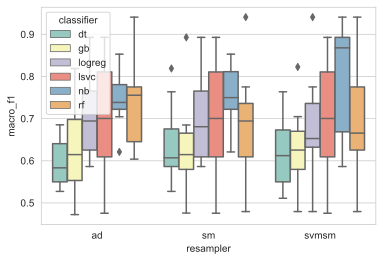

In [127]:
### visualize macro F1 scores by resampler
plot_f1_by_resampler = sns.boxplot(x='resampler', y='macro_f1', hue='classifier', data=df_f1_all_melted, palette='Set3')
plot_f1_by_resampler

In [128]:
### save plot as .png file
#output_name = 'f1_by_resampler'
#file_name = str('output/' + output_name + '_' + date_string + '.png')
#plt.savefig(file_name, bbox_inches='tight')
#plt.close()

<AxesSubplot:xlabel='classifier', ylabel='macro_f1'>

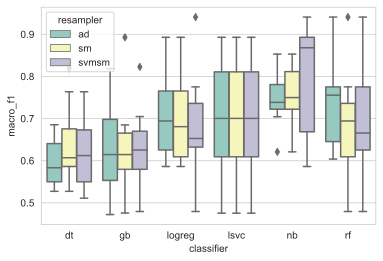

In [129]:
### visualize macro F1 scores by classifier
plot_f1_by_classifier = sns.boxplot(x='classifier', y='macro_f1', hue='resampler', data=df_f1_all_melted, palette='Set3') 
plot_f1_by_classifier

In [130]:
### save plot as .png file
#output_name = 'f1_by_classifier'
#file_name = str('output/' + output_name + '_' + date_string + '.png')
#plt.savefig(file_name, bbox_inches='tight')
#plt.close()

In [131]:
### run two-way ANOVA where DV = macro F1 score and IVs = classifier, resampler
anova_model = ols('macro_f1 ~ C(resampler) + C(classifier) + C(resampler):C(classifier)', data=df_f1_all_melted).fit()
stmod.stats.anova_lm(anova_model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,3.540151,1.0,289.377926,6.990852e-38
C(resampler),0.010737,2.0,0.438839,6.455485e-01
C(classifier),0.200478,5.0,3.277483,7.584543e-03
C(resampler):C(classifier),0.040876,10.0,0.334123,9.707564e-01
Residual,1.981853,162.0,NaN,NaN


In [132]:
### run post hoc comparisons by resampler if appropriate
anova_posthoc = pairwise_tukeyhsd(df_f1_all_melted['macro_f1'], df_f1_all_melted['resampler'])
print(anova_posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
    ad     sm   0.0022   0.9 -0.0489 0.0534  False
    ad  svmsm    0.002   0.9 -0.0492 0.0532  False
    sm  svmsm  -0.0003   0.9 -0.0514 0.0509  False
--------------------------------------------------


In [133]:
### run post hoc comparisons by classifier if appropriate
anova_posthoc = pairwise_tukeyhsd(df_f1_all_melted['macro_f1'], df_f1_all_melted['classifier'])
print(anova_posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    dt     gb     0.01    0.9 -0.0702 0.0902  False
    dt logreg    0.078 0.0621 -0.0022 0.1582  False
    dt   lsvc   0.0869 0.0253  0.0067 0.1671   True
    dt     nb   0.1499  0.001  0.0697 0.2302   True
    dt     rf   0.0881 0.0222  0.0079 0.1683   True
    gb logreg    0.068  0.148 -0.0123 0.1482  False
    gb   lsvc   0.0769 0.0689 -0.0033 0.1571  False
    gb     nb   0.1399  0.001  0.0597 0.2202   True
    gb     rf   0.0781 0.0614 -0.0021 0.1583  False
logreg   lsvc   0.0089    0.9 -0.0713 0.0891  False
logreg     nb    0.072 0.1065 -0.0083 0.1522  False
logreg     rf   0.0101    0.9 -0.0701 0.0904  False
  lsvc     nb    0.063 0.2144 -0.0172 0.1433  False
  lsvc     rf   0.0012    0.9  -0.079 0.0814  False
    nb     rf  -0.0618 0.2335 -0.1421 0.0184  False
---------------------------------------------------


## Model Validation - MCC

In [134]:
mcc_by_resampler = [sm_mcc, svmsm_mcc, ad_mcc] # create list of MCC scores across all classifiers and resamplers
dfs = {} # initialize empty dictionary

for each, df_name in zip(mcc_by_resampler, resampler_names): # store MCC scores by classifier in dictionary
    dfs[df_name] = pd.DataFrame(each, index=classifier_names) # can access dfs as: dfs['sm'], dfs['svmsm'], dfs['ad']

In [135]:
### combine MCC dataframes, grouped by classifier and resampler
df_mcc_all = pd.concat(dfs, keys=resampler_names, names=['resampler', 'classifier']).reset_index()
df_mcc_all

,resampler,classifier,0,1,2,3,4,5,6,7,8,9
0,sm,nb,0.709597,0.491343,0.253966,0.493567,0.649245,0.709299,0.600284,0.412335,0.465496,0.559259
1,sm,logreg,0.491343,0.287938,0.218218,0.490990,0.619324,0.785714,0.218218,0.287543,0.174449,0.650221
2,sm,dt,0.649628,0.254862,0.174449,0.209657,0.142857,0.559259,0.065795,0.366900,0.174449,0.357143
3,sm,rf,0.491343,-0.030643,0.287543,0.490990,0.434959,0.888106,0.218218,0.490990,0.218218,0.619324
4,sm,gb,0.357746,-0.043627,0.287543,0.287543,0.218218,0.785714,0.142857,0.394771,0.118217,0.218218
5,sm,lsvc,0.763912,0.287938,0.287543,0.619324,0.619324,0.785714,-0.044237,0.218218,0.174449,0.650221
6,svmsm,nb,0.763912,0.412823,0.888106,0.785714,0.763763,0.785714,0.218218,0.174449,0.315244,0.888106
7,svmsm,logreg,0.491343,-0.030643,0.434959,0.619324,0.434959,0.888106,0.434959,0.287543,0.174449,0.490990
8,svmsm,dt,0.282552,0.041682,0.118217,0.315244,0.097999,0.559259,0.080807,0.427125,0.174449,0.357143
9,svmsm,rf,0.619503,-0.030643,0.287543,0.619324,0.434959,0.888106,0.287543,0.357143,0.174449,0.619324


In [136]:
### pivot dataframe from wide to long format (all MCCs in the same column, identified by new fold variable)
df_mcc_all_melted = pd.melt(df_mcc_all, id_vars=['resampler', 'classifier'], var_name='fold', value_name='mcc')
df_mcc_all_melted = df_mcc_all_melted.sort_values(by=['resampler', 'classifier', 'fold'], ignore_index=True)
df_mcc_all_melted

,resampler,classifier,fold,mcc
0,ad,dt,0,0.395529
1,ad,dt,1,0.081920
2,ad,dt,2,0.174449
3,ad,dt,3,0.191383
4,ad,dt,4,0.118217
...,...,...,...,...
175,svmsm,rf,5,0.888106
176,svmsm,rf,6,0.287543
177,svmsm,rf,7,0.357143
178,svmsm,rf,8,0.174449


In [137]:
### write MCC data to CSV in output folder
output_name = 'mcc_all_models'
file_name = str('output/' + output_name + '_' + date_string + '.csv')
df_mcc_all_melted.to_csv(file_name, index=False) 

In [138]:
### get MCC scores, averaged across folds, and grouped by classifier and resampler
grouped_data = df_mcc_all_melted.groupby(['resampler', 'classifier'])
grouped_data_agg_mean = grouped_data['mcc'].aggregate(np.mean).reset_index().sort_values(by=['mcc'], ascending=False)

grouped_data_agg_std = grouped_data['mcc'].aggregate(np.std).reset_index().sort_values(by=['mcc'], ascending=False).rename(columns={"mcc": "std"})
grouped_data_agg = pd.merge(grouped_data_agg_mean, grouped_data_agg_std, how='outer', on=['resampler', 'classifier'])
grouped_data_agg

,resampler,classifier,mcc,std
0,svmsm,nb,0.599605,0.285121
1,sm,nb,0.534439,0.141909
2,ad,nb,0.517230,0.135435
3,ad,rf,0.509361,0.208804
4,ad,logreg,0.439693,0.207774
5,sm,lsvc,0.436240,0.285455
6,ad,lsvc,0.436240,0.285455
7,svmsm,lsvc,0.436240,0.285455
8,svmsm,rf,0.425725,0.266811
9,svmsm,logreg,0.422599,0.247320


In [139]:
### alternatively, reorder by classifier and resampler
grouped_data_agg.sort_values(by=['classifier','resampler'], ascending=True)

,resampler,classifier,mcc,std
17,ad,dt,0.200734,0.118354
12,sm,dt,0.295500,0.188050
16,svmsm,dt,0.245448,0.170556
15,ad,gb,0.253927,0.216121
14,sm,gb,0.276720,0.219170
13,svmsm,gb,0.279373,0.184384
4,ad,logreg,0.439693,0.207774
10,sm,logreg,0.422396,0.214285
9,svmsm,logreg,0.422599,0.247320
6,ad,lsvc,0.436240,0.285455


<AxesSubplot:xlabel='resampler', ylabel='mcc'>

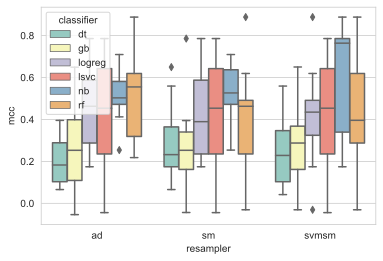

In [140]:
### visualize MCC scores by resampler
plot_mcc_by_resampler = sns.boxplot(x='resampler', y='mcc', hue='classifier', data=df_mcc_all_melted, palette='Set3')
plot_mcc_by_resampler

In [141]:
### save plot as .png file
#output_name = 'mcc_by_resampler'
#file_name = str('output/' + output_name + '_' + date_string + '.png')
#plt.savefig(file_name, bbox_inches='tight')
#plt.close()

<AxesSubplot:xlabel='classifier', ylabel='mcc'>

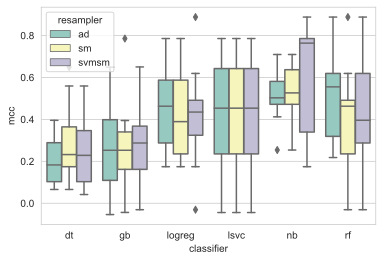

In [142]:
### visualize MCC scores by classifier
plot_mcc_by_classifier = sns.boxplot(x='classifier', y='mcc', hue='resampler', data=df_mcc_all_melted, palette='Set3')
plot_mcc_by_classifier

In [143]:
### save plot as .png file
#output_name = 'mcc_by_classifier'
#file_name = str('output/' + output_name + '_' + date_string + '.png')
#plt.savefig(file_name, bbox_inches='tight')
#plt.close()

In [144]:
### run two-way ANOVA where DV = MCC score and IVs = classifier, resampler
anova_model = ols('mcc ~ C(resampler) + C(classifier) + C(resampler):C(classifier)', data=df_mcc_all_melted).fit()
stmod.stats.anova_lm(anova_model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,0.402940,1.0,8.055102,0.005118
C(resampler),0.044951,2.0,0.449301,0.638867
C(classifier),0.893305,5.0,3.571581,0.004322
C(resampler):C(classifier),0.142668,10.0,0.285206,0.983755
Residual,8.103715,162.0,NaN,NaN


In [145]:
### run post hoc comparisons by resampler if appropriate
anova_posthoc = pairwise_tukeyhsd(df_mcc_all_melted['mcc'], df_mcc_all_melted['resampler'])
print(anova_posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
    ad     sm   0.0032   0.9 -0.1008 0.1071  False
    ad  svmsm   0.0086   0.9 -0.0953 0.1126  False
    sm  svmsm   0.0055   0.9 -0.0985 0.1094  False
--------------------------------------------------


In [146]:
### run post hoc comparisons by classifier if appropriate
anova_posthoc = pairwise_tukeyhsd(df_mcc_all_melted['mcc'], df_mcc_all_melted['classifier'])
print(anova_posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    dt     gb   0.0228    0.9 -0.1392 0.1848  False
    dt logreg    0.181 0.0188   0.019  0.343   True
    dt   lsvc    0.189  0.012   0.027  0.351   True
    dt     nb   0.3032  0.001  0.1412 0.4652   True
    dt     rf   0.2014 0.0058  0.0394 0.3634   True
    gb logreg   0.1582   0.06 -0.0038 0.3202  False
    gb   lsvc   0.1662 0.0407  0.0042 0.3282   True
    gb     nb   0.2804  0.001  0.1184 0.4424   True
    gb     rf   0.1787 0.0214  0.0167 0.3407   True
logreg   lsvc    0.008    0.9  -0.154   0.17  False
logreg     nb   0.1222 0.2554 -0.0398 0.2842  False
logreg     rf   0.0204    0.9 -0.1416 0.1824  False
  lsvc     nb   0.1142  0.329 -0.0478 0.2762  False
  lsvc     rf   0.0124    0.9 -0.1496 0.1744  False
    nb     rf  -0.1018 0.4634 -0.2638 0.0602  False
---------------------------------------------------


# Final Evaluation on Test Set

In [147]:
def eval_test_model_labelled(cv_results):
    """ Evaluate performance of an already trained and cross-validated model on the unseen test set.
    
    Args:
        cv_results (string): Name of model that has been already trained and cross-validated.
    
    Returns:
        f1_scores (list): List of F1 scores by fold.
        mcc_scores (list): List of MCC scores by fold.
    """
    
    f1_scores = []
    mcc_scores = []
    for fold_id, cv_model in enumerate(cv_results["estimator"]):
        f1_scores.append(
            f1_score(y_test, cv_model.predict(X_test), average = 'macro')
        )
        mcc_scores.append(
            matthews_corrcoef(y_test, cv_model.predict(X_test))
        )

    print(f"Mean macro F1: "
        f"{np.mean(f1_scores):.3f} / SD: {np.std(f1_scores):.3f}")
    print(f"Macro F1 by fold: {f1_scores}")

    print(f"Mean MCC: "
        f"{np.mean(mcc_scores):.3f} / SD: {np.std(mcc_scores):.3f}")
    print(f"MCC by fold: {mcc_scores}")

    return f1_scores, mcc_scores

In [148]:
### apply already trained model from cross-validation to the unseen test set
### if performance metrics are similar here as they were during cross-validation above, provides some evidence that the model can successfully generalize to unseen data
eval_test_model = eval_test_model_labelled(nb_svmsm)

Mean macro F1: 0.807 / SD: 0.020
Macro F1 by fold: [0.768472906403941, 0.7934065934065934, 0.8379110727922158, 0.7934065934065934, 0.8068823831535696, 0.8234741784037558, 0.821969696969697, 0.8234741784037558, 0.7915999507328488, 0.8068823831535696]
Mean MCC: 0.617 / SD: 0.039
MCC by fold: [0.5442051700319464, 0.5890075466692581, 0.6765878252488271, 0.5890075466692581, 0.6168424047228069, 0.6548958029239424, 0.6439393939393939, 0.6548958029239424, 0.5838775401564222, 0.6168424047228069]


# Final Predictions on Test Set

In [149]:
### create dataframe with test set data and document IDs
X_test.rename('doc_id').reset_index() # add index as column, rename that column to 'doc_id'
X_test_df = pd.DataFrame(X_test).reset_index() # convert it to a dataframe
X_test_df.columns = ['doc_id', 'processed_text'] # name that dataframe's columns
X_test_df['doc_id'] += 1 # doc_id is zero-indexed, so add one to match with original dataset

In [150]:
def pred_test_model_labelled(classifier, resampler=None, count=False, ngram='uni'):
    """ Re-train a model on combined train and validation sets, and then make predictions on the unseen test set.
    
    Args:
        classifier (str): Name of classifier to be used in model.
        resampler (str, optional): Name of resampler to be used in model. Defaults to None.
        count (bool, optional): Set whether the vectorizer uses count (True) or TF-IDF (False). Defaults to False.
        ngram (str, optional): Set whether the vectorizer uses unigrams ('uni') or unigrams and bigrams ('unibi'). Defaults to 'uni'. 
    
    Returns:
        test_metrics (tuple): Named tuple 'metrics', with fields 'f1_list', 'precision_list', 'recall_list', and 'accuracy_list'
            containing classification metrics by each fold.
        y_pred (array): Model's predictions made on unseen test set.
    """
    if count == True:
        if ngram == 'uni':
            vectorizer = vect
        elif ngram == 'unibi':
            vectorizer = vect_unibi
    elif count == False:
        if ngram == 'uni': 
            vectorizer = t_vect
        elif ngram == 'unibi':
            vectorizer = t_vect_unibi
        
    print('Classifier:', classifier, '/', 'Resampler:', resampler, '/', 'Vectorizer:', vectorizer)

    model = Pipeline(
        [
            ("vectorizer", vectorizer),
            ("resampler", resampler),
            ("classifier", classifier)
        ]
    )

    model.fit(X_train_val, y_train_val)
    y_pred = model.predict(X_test)

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    mcc = matthews_corrcoef(y_test, y_pred)
    macro_precision = precision_score(y_test, y_pred, average='macro')
    macro_recall = recall_score(y_test, y_pred, average='macro')
    print(f'> Macro F1: {macro_f1:.3f}')
    print(f'> MCC: {mcc:.3f}')
    print(f'> Macro Precision: {macro_precision:.3f}')
    print(f'> Macro Recall: {macro_recall:.3f}')
    print(classification_report(y_test, y_pred))
    print(pd.crosstab(y_test, y_pred, rownames=['human_labelled'], colnames=['model_predicted'], margins=True))
    
    test_metrics = namedtuple('test_metrics', ['macro_f1', 'mcc', 'macro_precision', 'macro_recall'])
    return test_metrics(macro_f1, mcc, macro_precision, macro_recall), y_pred

In [151]:
### re-train model on full train and validation set, then make predictions on test set of labelled data
### arguments supplied here (classifier, resampler) should be chosen based on your cross-validation and final evaluation results above
pred_test_model = pred_test_model_labelled(nb, svmsm, count=True)

Classifier: MultinomialNB() / Resampler: SVMSMOTE(random_state=317) / Vectorizer: CountVectorizer()
> Macro F1: 0.781
> MCC: 0.566
> Macro Precision: 0.755
> Macro Recall: 0.813
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       176
         1.0       0.53      0.67      0.59        12

    accuracy                           0.94       188
   macro avg       0.76      0.81      0.78       188
weighted avg       0.95      0.94      0.94       188

model_predicted  0.0  1.0  All
human_labelled                
0.0              169    7  176
1.0                4    8   12
All              173   15  188


In [152]:
### add model's predictions as new column to dataframe of test set with document IDs and processed texts
X_test_df['model_predicted'] = pred_test_model[1]
X_test_df

,doc_id,processed_text,model_predicted
0,510,walk kindergarten class tadpole mother volunte...,0.0
1,583,prepare test assignment recall past memory fai...,0.0
2,645,memory fuzzy know happen recall specific feel ...,1.0
3,897,event childhood treat wound scrape burn small ...,0.0
4,154,remember thing person say past,0.0
...,...,...,...
183,338,couple year ago dad got sting bee die lady com...,0.0
184,224,memory difficulty face past year think want is...,0.0
185,819,trip family take summer vacation alberta memor...,0.0
186,880,brother wedding day hang family help prepare c...,0.0


In [153]:
### merge in original data linked to each document (e.g., human labels, raw texts)
test_df = pd.merge(X_test_df, labelled_data, how='outer', on=['doc_id', 'processed_text'])
test_df

,doc_id,processed_text,model_predicted,text,human_labelled,tokenized_text,processed_tokens
0,510,walk kindergarten class tadpole mother volunte...,0.0,I was walking with my kindergarten class to se...,0.0,"(I, was, walking, with, my, kindergarten, clas...","[walk, kindergarten, class, tadpole, mother, v..."
1,583,prepare test assignment recall past memory fai...,0.0,If I were to prepare for a test or an assignme...,0.0,"(If, I, were, to, prepare, for, a, test, or, a...","[prepare, test, assignment, recall, past, memo..."
2,645,memory fuzzy know happen recall specific feel ...,1.0,"Memory is fuzzy, I know something has happened...",0.0,"(Memory, is, fuzzy, ,, I, know, something, has...","[memory, fuzzy, know, happen, recall, specific..."
3,897,event childhood treat wound scrape burn small ...,0.0,"The event is from my childhood. I was ""treatin...",0.0,"(The, event, is, from, my, childhood, ., I, wa...","[event, childhood, treat, wound, scrape, burn,..."
4,154,remember thing person say past,0.0,Remembering things a person has said and done ...,0.0,"(Remembering, things, a, person, has, said, an...","[remember, thing, person, say, past]"
...,...,...,...,...,...,...,...
935,944,memory dog bring home time small rainy day pla...,NaN,Memory of my dog being brought home for the fi...,0.0,"(Memory, of, my, dog, being, brought, home, fo...","[memory, dog, bring, home, time, small, rainy,..."
936,945,remember lot thing comment regret way say reca...,NaN,i remember lots of things. a comment that i re...,0.0,"(i, remember, lots, of, things, ., a, comment,...","[remember, lot, thing, comment, regret, way, s..."
937,946,sit watch specific get par funny remember laug...,NaN,I was just sitting and watching a specific sho...,0.0,"(I, was, just, sitting, and, watching, a, spec...","[sit, watch, specific, get, par, funny, rememb..."
938,947,recurrent intrusive recollection think questio...,NaN,"No recurrent, intrusive recollections. I thoug...",1.0,"(No, recurrent, ,, intrusive, recollections, ....","[recurrent, intrusive, recollection, think, qu..."


In [154]:
### get a random sample of cases in the test set based on whether the model predicted them to be valid (0) or invalid (1)
test_df.groupby('model_predicted').apply(lambda x: x.sample(n=10, random_state=317))

doc_id  \
model_predicted               
0.0             59      904   
                71       41   
                77      588   
                91      740   
                44      422   
                137     667   
                68      850   
                6       188   
                7       378   
                10      158   
1.0             148     150   
                181     636   
                20      624   
                169     142   
                58       40   
                86      707   
                76      218   
                2       645   
                89      126   
                47      116   

                                                        processed_text  \
model_predicted                                                          
0.0             59   sport game remember random game play year scor...   
                71   place boyfriend visit waterloo recollection ce...   
                77                    activity remind past memory come   
                91   europe visit family year ago time sister pregn...   
                44   enjoyable event bring feeling fear sadness jea...   
                137  young mother hug long time minute bed upset se...   
                68   year old go camping trip family carefree kid m...   
                6    walk university building earbud ear cry listen...   
                7    fight boyfriend scream feel worthless scared p...   
                10    general situation mistake uncomfortable pop head   
1.0             148     difficult remember event remember try remember   
                181                 remember kind happen moment forget   
                20                                            remember   
                169                                            private   
                58                                     decline respond   
                86   have trouble recall specific memory right know...   
                76                                     memory accurate   
                2    memory fuzzy know happen recall specific feel ...   
                89   remind event unfold feeling attach strengthen ...   
                47                                      remember right   

                     model_predicted  \
model_predicted                        
0.0             59               0.0   
                71               0.0   
                77               0.0   
                91               0.0   
                44               0.0   
                137              0.0   
                68               0.0   
                6                0.0   
                7                0.0   
                10               0.0   
1.0             148              1.0   
                181              1.0   
                20               1.0   
                169              1.0   
                58               1.0   
                86               1.0   
                76               1.0   
                2                1.0   
                89               1.0   
                47               1.0   

                                                                  text  \
model_predicted                                                          
0.0             59   Before my sports game I remembered a random ga...   
                71   It was a place where I have been with a former...   
                77   i would be doing an activity that somehow remi...   
                91   Being in Europe visiting my family, 3 years ag...   
                44   It was not an enjoyable event. It brings feeli...   
                137  When I was young my mother used to hug me for ...   
                68   It was when I was 8 years old, and I went on a...   
                6    I was walking out of a university building, wi...   
                7    I had a fight with my boyfriend where he screa...   
              

In [155]:
### write data for labelled subset (including predictions on test set) to CSV in output folder
output_name = 'test_model_predictions'
file_name = str('output/' + output_name + '_' + date_string + '.csv')
test_df.to_csv(file_name, index=False) 

# Predict on Unlabelled Data

In [156]:
### store data from labelled subset
X_labelled = labelled_data['processed_text']
y_labelled = labelled_data['human_labelled']

### store data from unlabelled subset
X_unlabelled = unlabelled_data['processed_text']
unlabelled_doc_id = unlabelled_data['doc_id']

In [157]:
def pred_model_unlabelled(classifier, resampler=None, count=False, ngram='uni'):
    """ Re-train a model on the labelled subset (i.e., combined train, validation, and test sets), and then make predictions on the unlabelled subset.
    
    Args:
        classifier (str): Name of classifier to be used in model.
        resampler (str, optional): Name of resampler to be used in model. Defaults to None.
        count (bool, optional): Set whether the vectorizer uses count (True) or TF-IDF (False). Defaults to False.
        ngram (str, optional): Set whether the vectorizer uses unigrams ('uni') or unigrams and bigrams ('unibi'). Defaults to 'uni'. 

    Returns:
        y_pred_df (dataframe): Dataframe of model's predictions on unlabelled subset and document IDs.
    """
    if count == True:
        if ngram == 'uni':
            vectorizer = vect
        elif ngram == 'unibi':
            vectorizer = vect_unibi
    elif count == False:
        if ngram == 'uni': 
            vectorizer = t_vect
        elif ngram == 'unibi':
            vectorizer = t_vect_unibi

    print('Classifier:', classifier, '/', 'Resampler:', resampler, '/', 'Vectorizer:', vectorizer)

    model = make_pipeline(vectorizer, resampler, classifier)

    model.fit(X_labelled, y_labelled)
    y_pred = model.predict(X_unlabelled)

    y_pred_df = pd.DataFrame(y_pred, unlabelled_doc_id, columns=['model_predicted'])
    print(y_pred_df)
    return y_pred_df

In [158]:
### re-train model on full labelled subset (train, validation, and test set), then make predictions on unlabelled data
### arguments supplied here (classifier, resampler) should be chosen based on cross-validation and final evaluation results above
unlabelled_model = pred_model_unlabelled(nb, svmsm, count=True)

Classifier: MultinomialNB() / Resampler: SVMSMOTE(random_state=317) / Vectorizer: CountVectorizer()
        model_predicted
doc_id                 
950                 0.0
951                 1.0
952                 0.0
953                 0.0
955                 0.0
...                 ...
3620                0.0
3621                0.0
3622                0.0
3623                0.0
3624                1.0

[2634 rows x 1 columns]


In [159]:
### count how many valid (0) and invalid (1) cases were predicted to be in the unlabelled subset by the model
print(unlabelled_model.value_counts())
print("Predicted invalid cases: " f"{(len(unlabelled_model[(unlabelled_model['model_predicted'] == 1)]) / len(unlabelled_model))*100:.2f}%")


model_predicted
0.0                2464
1.0                 170
dtype: int64
Predicted invalid cases: 6.45%


In [160]:
### merge in original data linked to each document (e.g., processed texts, raw texts)
unlabelled_predictions_df = pd.merge(unlabelled_data, unlabelled_model, how='outer', on=['doc_id'])
unlabelled_predictions_df

,doc_id,text,human_labelled,tokenized_text,processed_tokens,processed_text,model_predicted
0,950,My most recent memory was from my first year o...,NaN,"(My, most, recent, memory, was, from, my, firs...","[recent, memory, year, university, person, dat...",recent memory year university person date time...,0.0
1,951,The memory is blurry and dream-like. I doubt w...,NaN,"(The, memory, is, blurry, and, dream, -, like,...","[memory, blurry, dream, like, doubt, event, oc...",memory blurry dream like doubt event occur lik...,1.0
2,952,I was often bullied by my peers in primary sch...,NaN,"(I, was, often, bullied, by, my, peers, in, pr...","[bully, peer, primary, school, memory, peer, m...",bully peer primary school memory peer make fun...,0.0
3,953,I had previously slipped on ice before. Recent...,NaN,"(I, had, previously, slipped, on, ice, before,...","[previously, slip, ice, recently, slip, remind...",previously slip ice recently slip remind momen...,0.0
4,955,A memory that hurt me emotionally to a great e...,NaN,"(A, memory, that, hurt, me, emotionally, to, a...","[memory, hurt, emotionally, great, extent]",memory hurt emotionally great extent,0.0
...,...,...,...,...,...,...,...
2629,3620,I've had memories come up from when I got into...,NaN,"(I, 've, had, memories, come, up, from, when, ...","[memory, come, get, relationship, year, certai...",memory come get relationship year certain time...,0.0
2630,3621,My dad told a story of making coffee at work t...,NaN,"(My, dad, told, a, story, of, making, coffee, ...","[dad, tell, story, make, coffee, work, funny]",dad tell story make coffee work funny,0.0
2631,3622,memory of playing a sport and winning. Very e...,NaN,"(memory, of, playing, a, sport, and, winning, ...","[memory, play, sport, win, enlighte, joyful]",memory play sport win enlighte joyful,0.0
2632,3623,Memories with my ex-girlfriend tends to sponta...,NaN,"(Memories, with, my, ex, -, girlfriend, tends,...","[memories, ex, girlfriend, tend, spontaneously...",memories ex girlfriend tend spontaneously appe...,0.0


In [161]:
### get a random sample of cases in the test set based on whether the model predicted them to be valid (0) or invalid (1)
unlabelled_predictions_df.groupby('model_predicted').apply(lambda x: x.sample(n=6, random_state=317))

doc_id  \
model_predicted                
0.0             2117    3101   
                2152    3136   
                718     1679   
                2217    3201   
                545     1506   
                1500    2472   
1.0             2050    3032   
                1125    2092   
                2472    3461   
                1711    2689   
                559     1520   
                1018    1983   

                                                                   text  \
model_predicted                                                           
0.0             2117  felt very scared and small - felt Powerless - ...   
                2152                                 My parents divorce   
                718   When I was younger, I climbed up a mountain vi...   
                2217  i was at a party, everybody was super drunk. i...   
                545   Thoughts of someone who used to be very close ...   
                1500  overtime that I walk through any hallway, I wi...   
1.0             2050  Mostly a traumatizing event but I don't like t...   
                1125                                I prefer not to say   
                2472  i dont remember exactly what the event was but...   
                1711  Can't remember off the top of my head as there...   
                559                                 I don't remember :(   
                1018  Being anxious, and having to move back from Mo...   

                      human_labelled  \
model_predicted                        
0.0             2117             NaN   
                2152             NaN   
                718              NaN   
                2217             NaN   
                545              NaN   
                1500             NaN   
1.0             2050             NaN   
                1125             NaN   
                2472             NaN   
                1711             NaN   
                559              NaN   
                1018             NaN   

                                                         tokenized_text  \
model_predicted                                                           
0.0             2117  (felt, very, scared, and, small, -, felt, Powe...   
                2152                             (My, parents, divorce)   
                718   (When, I, was, younger, ,, I, climbed, up, a, ...   
                2217  (i, was, at, a, party, ,, everybody, was, supe...   
                545   (Thoughts, of, someone, who, used, to, be, ver...   
                1500  (overtime, that, I, walk, through, any, hallwa...   
1.0             2050  (Mostly, a, traumatizing, event, but, I, do, n...   
                1125                          (I, prefer, not, to, say)   
                2472  (i, do, nt, remember, exactly, what, the, even...   
                1711  (Ca, n't, remember, off, the, top, of, my, hea...   
                559                          (I, do, n't, remember, :()   
                1018  (Being, anxious, ,, and, having, to, move, bac...   

                                                       processed_tokens  \
model_predicted                                                           
0.0             2117  [feel, scared, small, feel, powerless, usually...   
                2152                                  [parent, divorce]   
                718   [young, climb, mountain, hiking, trail, vacati...   
                2217  [party, everybody, super, drunk, dark, bright,...   
                545   [thought, close, flash, mind, certain, thing, ...   
                1500  [overtime, walk, hallway, feel, like, old, dog...   
1.0             2050                  [traumatizing, event, like, talk]   
                1125                                           [prefer]   
                2472  [nt, remember, exactly, event, remember, like,...   
                1711                        [remember, head, countless]   
          

In [162]:
### write data for unlabelled subset (including predictions on unlabelled subset) to CSV in output folder
output_name = 'unlabelled_model_predictions'
file_name = str('output/' + output_name + '_' + date_string + '.csv')
unlabelled_predictions_df.to_csv(file_name, index=False)